# VGG16

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam

from torchvision.datasets.cifar import CIFAR10 # class가 10개
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

In [3]:
custom_transform = Compose( # 과적합(오버피팅) 방지 => 이미지 변환
    [
        RandomCrop((32,32), padding=4), # 패딩으로 감싸고 랜덤으로 자르기
        RandomHorizontalFlip(p=0.5), # 좌우 반전(전체 이미지에서 50% 확률로)
        T.ToTensor(),
        # 컬러 이미지는 rgb간의 편차(255)가 커서 정규화 필요
        Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)) # rgb라 3개씩
    ]
)

train_data = CIFAR10(root='../files', train=True, download=True, transform=custom_transform)
test_data = CIFAR10(root='../files', train=False, download=True, transform=custom_transform)

100%|██████████| 170M/170M [00:43<00:00, 3.92MB/s] 


(32, 32, 3)


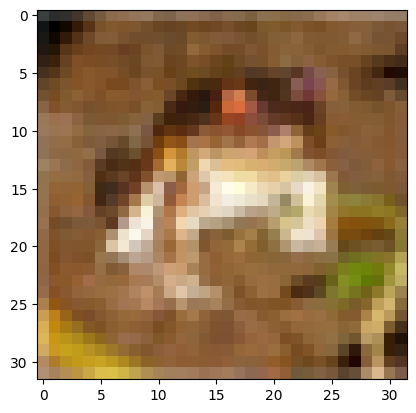

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
print(train_data.data[0].shape)

plt.imshow(train_data.data[0])
plt.show()

train_data.data[0]

In [5]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
train_data.targets[0]

6

In [7]:
train_data.data[0].shape

(32, 32, 3)

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # (32, 32, 3) => [32, 3, 32, 32] 채널 순서 변환
test_loader = DataLoader(train_data, batch_size=32, shuffle=False)

img_data = iter(train_loader)
images, labels = next(img_data)

images.shape

torch.Size([32, 3, 32, 32])

In [11]:
img_data = images[0]
img_data = img_data.numpy()
img_data.shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9797254].


(32, 32, 3)


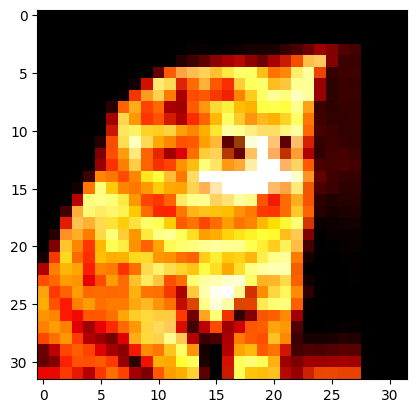

In [319]:
img_show = img_data.transpose(1, 2, 0) # 채널 순서 변경
print(img_show.shape)
plt.imshow(img_show) 
plt.show()

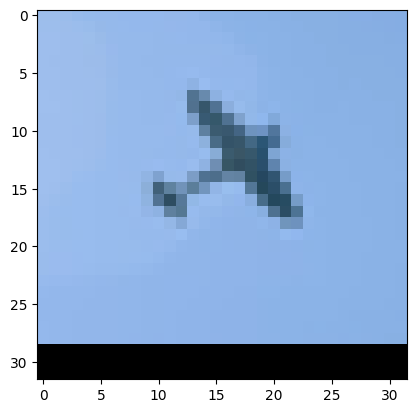

In [12]:
def _denormalize(tensor_image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    
    return tensor_image * std + mean

def view_img(tensor_image):
    mean=(0.4914, 0.4822, 0.4465)
    std=(0.247, 0.243, 0.261)
    
    reset_img_data = _denormalize(tensor_image, mean, std)
    numpy_img_data = reset_img_data.numpy()
    plt.imshow(np.transpose(numpy_img_data,(1,2,0)))
    plt.show()
    
view_img(images[0])

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1) # stride 기본값 1
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # kernel_size == pooling size
        
    def forward(self, x): # self : 객체의 memory 구분값을 포함
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        return x
    
class Vgg16(nn.Module):
    def __init__(self, num_classes):
        super(Vgg16, self).__init__()
        
        # 32 * 32 input
        # 3 -> 16 -> 32 특징수을 체크 (이미지 사이즈는 작아짐 - 아래 값들과 별도)
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16) # 16 * 16 
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64) # 8 * 8
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128) # 4 * 4
        
        # 특징수 * 이미지 사이즈 = 특징(256가지 == 장수)을 가진 이미지(4*4 size)로 input 이미지를 필터링
        # 256 * 4 * 4 = 4096(out_channels * h * w) - in_features : input 이미지 크기에 맞게 계산해서 수정 필요(중요)
        self.fc1 = nn.Linear(in_features=4096, out_features=2048) # out_features부터는 임의값 사용
        self.fc2 = nn.Linear(in_features=2048, out_features=256) 
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes) 
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = torch.flatten(x, start_dim=1) # 평탄화
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

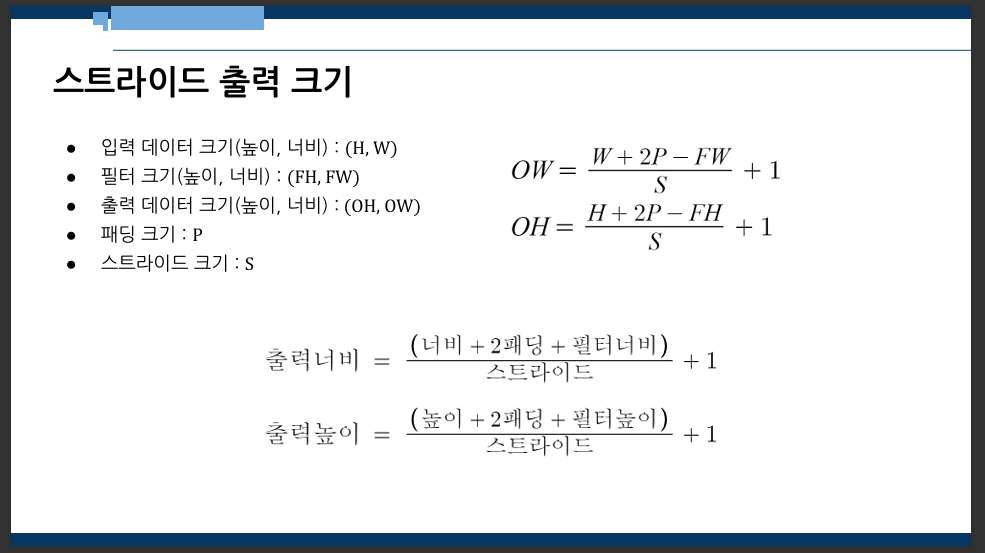

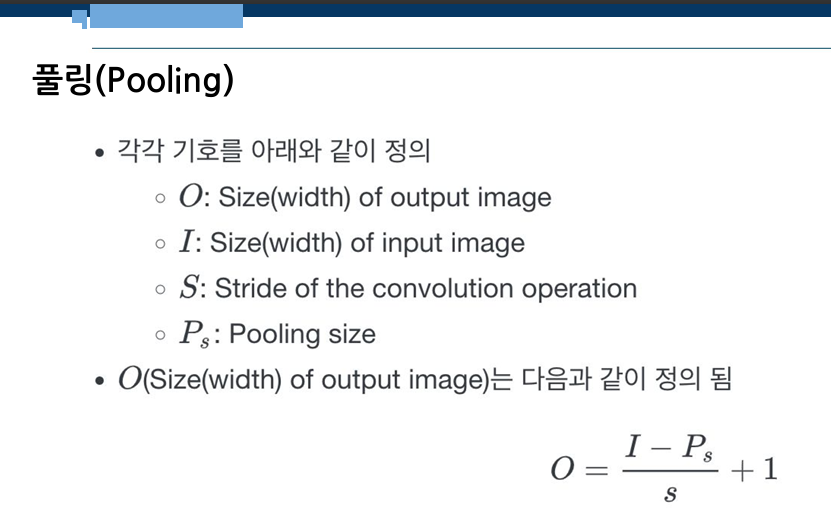

In [15]:
model = Vgg16(10)
model

Vgg16(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=25

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import tqdm # 반복문의 진행률 시각화

writer = SummaryWriter()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

custom_lr = 1e-3
optim = Adam(model.parameters(), lr=custom_lr)
criterion = nn.CrossEntropyLoss()

model.to(device)
epochs = 10
step = 0

for epoch in range(epochs):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = criterion(preds, label.to(device))
        
        loss.backward()
        optim.step()
        
        writer.add_scalar('Loss/train', loss.item(), step)
        step += 1
        
    print(f'epoch : {epoch + 1} - loss : {loss.item()}')    
    
# 결과 웹 조회
# tensorboard --logdir=model.runs
# http://localhost:6006/?darkMode=true#timeseries

100%|██████████| 1563/1563 [02:44<00:00,  9.52it/s]

epoch : 1 - loss : 1.1861093044281006


In [18]:
from torchvision.models import vgg16

# 동물 (487개): 개, 고양이, 사자, 코끼리, 곰 등
# 식물 (122개): 꽃, 나무, 풀, 작물 등
# 사물 (440개): 자동차, 비행기, 배, 자전거, 가구 등
# 자연 (114개): 풍경, 하늘, 바다, 산, 강 등
# 인물 (137개): 사람, 얼굴, 손, 발 등
# image-net(class : 1000)의 data로 가중치가 업데이트 된 상태를 사용
# 내가 분류하려는 것과 class가 비슷한 경우 활용 - image 수가 너무 적은 경우는 고려
model = vgg16(pretrained=True)
model

# Dropout(p=0.5, inplace=False)
# Dropout : 작거나 의미없는 가중치를 제거(지정한 퍼센트값(p))의 확률만큼으로 제거)
# 과적합 문제(이미지 처리의 큰 문제)를 해결하기 위함

/Users/minwoojeon/J/Code/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/minwoojeon/J/Code/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/minwoojeon/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 58.9MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# 모델 사용시 분류기(classifier)만 편집하여 사용 
# input - 첫 in_features : 이미지 사이즈에 따라 계산, 
# output - 마지막 out_features : 원하는 분류수

# default classifier
# (classifier): Sequential(
#   (0): Linear(in_features=25088, out_features=4096, bias=True)
# default input - 25088 : 224 * 224 사이즈 이미지
fc = nn.Sequential(
    nn.Linear(4096, 4096), # nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 10)
)

model.classifier = fc
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1